In [18]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [20]:
import numpy as np
import tensorflow as tf
import os
from face_detection import face_detector

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"
!echo ${CUDA_VISIBLE_DEVICES}

0


In [25]:
class E2EFace(object):
    def __init__(self):
        self.landmark_model = LandmarkModel('/barn2/yuan/saved_model/3D-FAN-NHWC-0')    # accept NHWC
        self.detection_model = face_detector.FaceDetector()
        return
    
    def get_bbx(self, img):

        # assume img is in uint8 bgr format
        frame_bgr_hwc_uint8 = img
        #frame_rgb_hwc_uint8 = cv2.cvtColor(frame_bgr_hwc_uint8, cv2.COLOR_BGR2RGB)

        box = self.detection_model.predict_1x1(x=img)

        y_min = int(box[0] * img.shape[0])
        x_min = int(box[1] * img.shape[1])
        y_max = int(box[2] * img.shape[0])
        x_max = int(box[3] * img.shape[1])
        #print(scores[0][0])
        #cv2.rectangle(frame_bgr_hwc_uint8, (x_min, y_min), (x_max, y_max), (0, 255, 0), 2)
        return x_min, y_min, x_max, y_max

    def get_landmark_v2(self, img, x_min, y_min, x_max, y_max):


        center = torch.FloatTensor(
            [x_max - (x_max - x_min) / 2.0, y_max - (y_max - y_min) / 2.0])
        center[1] = center[1] - (y_max - y_min) * 0.12
        scale = (x_max - x_min + y_max - y_min) / 195.0

        inp = uo.crop(img, center, scale)

        inp = inp.astype(np.float32) / 255.0

        out = self.landmark_model.predict([inp])[0]  # (64, 64, 68)

        inp_flipped = uo.flip(inp).numpy()  # (256, 256, 3)

        #print(inp_flipped.shape)

        out_3 = self.landmark_model.predict([inp_flipped])[0]


        #print('out_3 shape', out_3.shape)
        out_4 = uo.flip(out_3, is_label=True) # (64, 64, 68)
        out += out_4
        #print('out_4 shape', out_4.shape)

        pts, pts_img = uo.get_preds_fromhm(out, center, scale)
        pts, pts_img = pts.view(68, 2) * 4, pts_img.view(68, 2) # (68, 2)

        # convert face back
        pts = [uo.transform(pt, center, scale, 256, invert=True) for pt in pts.tolist()]
        pts = [pt.numpy() for pt in pts]
        pts = np.array(pts)

        return pts

    def predict_v2(self, img, with_bbx=False):

        # NOTE: face_detector accepts uint8 HWC RGB format
        #rects = face_detector(frame_rgb_hwc_uint8, 1)
        #is_rect_exist, left, right, top, bottom = preprocess_rects(rects)
        #is_rect_exist, left, right, top, bottom = True, 269,375, 473, 578i


        left, top, right, bottom = self.get_bbx(img)
        bbx = [left, top, right, bottom]
        if not with_bbx:
            return self.get_landmark_v2(img, left, top, right, bottom)
        else:
            return self.get_landmark_v2(img, left, top, right, bottom), bbx

class LandmarkModel(object):
    def __init__(self, model_dir: str):
        config = tf.ConfigProto()
        config.gpu_options.allow_growth=True
        graph = tf.Graph()
        self.sess = tf.Session(config=config, graph=graph)
        with graph.as_default():
            tf.saved_model.loader.load(self.sess, [tf.saved_model.tag_constants.SERVING], model_dir)
            self.x = tf.get_default_graph().get_tensor_by_name("x:0")
            self.y = tf.get_default_graph().get_tensor_by_name("y:0")
            init_op = tf.global_variables_initializer()
        self.sess.run(init_op)
        return

    def predict(self, x):
        return self.sess.run(self.y, {self.x:x})


In [16]:
import matplotlib.pyplot as plt
from scipy.interpolate import BSpline
def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]

def find_nearest_idx(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return idx

def plot_cdf(x, save_path=None):
    num_bins = x.shape[0]
    counts, bin_edges = np.histogram (x, bins=num_bins)
    cdf = np.cumsum (counts)

    x_axis = bin_edges[1:]
    x_axis = np.insert(x_axis, 0, x_axis[0])
    x_axis = np.insert(x_axis, 0, 0)

    y_axis = cdf/cdf[-1]
    y_axis = np.insert(y_axis, 0, 0)
    y_axis = np.insert(y_axis, 0, 0)
    
    n_draw = int(min(find_nearest_idx(y_axis, 0.9) * 2, y_axis.shape[0]*0.98))
    x_axis = x_axis[:n_draw] * 100
    y_axis = y_axis[:n_draw] * 100
    
    plt.xlim(0, np.max(x_axis))
    plt.ylim(0, 100)
    plt.ylabel('sample %')
    plt.xlabel('nme %')

    #x_axis_finegrain = np.linspace(x_axis.min(), x_axis.max(), int(90000 / num_bins) + num_bins)
    #y_axis_smooth = BSpline(x_axis ,y_axis,x_axis_finegrain)
    plt.grid()
    plt.plot(x_axis, y_axis)
    if save_path is not None:
        plt.savefig(save_path)
    return

In [44]:
import scipy
print(scipy.__version__)

1.1.0


In [81]:
from face_landmark import load_dataset
from face_landmark.metric import nme
from face_landmark.metric import nme_v2
from face_landmark.fan_tf import util_official as uo
import torch
import matplotlib.pyplot as plt 
from matplotlib.patches import Circle
from face_detection import face_detector
import PIL

def run_benchmark(dataset_dir=None, iterator=None):
    if dataset_dir is not None:
        iterator = load_dataset.DatasetIterator(dataset_dir)
    e2e_model = E2EFace()
    nmes = []
    for i, (anno, img) in enumerate(iterator):
        anno_3d = anno[1]
        rvalue = e2e_model.predict_v2(img, with_bbx=True)
        if rvalue is not None:
            landmarks, bbx = rvalue
            d = np.sqrt((bbx[2] - bbx[0])*(bbx[3]-bbx[1]))
            nme_score_3d = nme(landmarks, anno_3d, d)
            nmes.append(nme_score_3d) 
    return nmes

class Dataset(object):
    def __init__(self):
        self.detector = face_detector.FaceDetector()
        self.landmark_xmin_stat = []
        self.landmark_ymin_stat = []
        self.landmark_xmax_stat = []
        self.landmark_ymax_stat = []
        self.aspect_ratio_stat = []
        
    def auto_crop(self, image, landmark):
        try:
            bbx = self.detector.predict_1x1(image)
        except face_detector.DetectionError:
            bbx = np.array([0.0, 0.0, 1.0, 1.0])
        height_raw, width_raw, _ = image.shape
        
        # landmarks 
        landmark_xmin = landmark[:,0].min()
        landmark_xmax = landmark[:,0].max()
        landmark_ymin = landmark[:,1].min()
        landmark_ymax = landmark[:,1].max()
        
        self.landmark_xmin_stat.append((bbx[1] - landmark_xmin) / (bbx[3] - bbx[1]))
        self.landmark_xmax_stat.append((bbx[3] - landmark_xmax) / (bbx[3] - bbx[1]))
        self.landmark_ymin_stat.append((bbx[0] - landmark_ymin) / (bbx[2] - bbx[0]))
        self.landmark_ymax_stat.append((bbx[2] - landmark_ymax) / (bbx[2] - bbx[0]))
        self.aspect_ratio_stat.append((bbx[2] - bbx[0]) / (bbx[3] - bbx[1]))
        
        crop_xmin = max(min(bbx[1], landmark_xmin), 0.0)
        crop_xmax = min(max(bbx[3], landmark_xmax), 1.0)
        crop_ymin = max(min(bbx[0], landmark_ymin), 0.0)
        crop_ymax = min(max(bbx[2], landmark_ymax), 1.0)
        
        crop_width = crop_xmax - crop_xmin
        crop_height = crop_ymax - crop_ymin
                
        # cropped origin  [0, 1)
        origin_x = bbx[1] 
        origin_y = bbx[0]
        
        # shift
        scale_x = 1.0 / crop_width
        scale_y = 1.0 / crop_height
        shift_x = - crop_xmin / crop_width
        shift_y = - crop_ymin / crop_height
        
        
        transform_matrix = np.array([[scale_x, 0, shift_x],
                                     [0, scale_y, shift_y],
                                     [0, 0, 1]]).astype(np.float32)
        landmark_e = np.ones([68, 3], dtype=np.float32)
        landmark_e[:, :2] = landmark
        landmark = np.matmul(landmark_e, transform_matrix.T)[:, :2]
        image = image[int(height_raw*crop_ymin):int(height_raw*crop_ymax), int(width_raw*crop_xmin):int(width_raw*crop_xmax)]
        return image, landmark
    
    def auto_crop_and_resize(self, image, landmark, target_size=256):
        image, landmark = self.auto_crop(image, landmark)
        image = PIL.Image.fromarray(image)
        image = image.resize([target_size, target_size], resample=PIL.Image.BILINEAR)
        return image, landmark


def run_imagemark(dataset, dataset_dir=None, iterator=None, render=True):
    
    if dataset_dir is not None:
        iterator = load_dataset.DatasetIterator(dataset_dir)
    
    nmes = []
    for i, (anno, img) in enumerate(iterator):
        anno_3d = anno[1]

        img, anno = dataset.auto_crop_and_resize(img, anno_3d / 450.0)
        #print(anno)
        if render:
            fig,ax = plt.subplots(1)
            ax.set_aspect('equal')


            for i in range(68):
                x, y = anno[i]
                x = int(x*256)
                y = int(y*256)
                circ = Circle((x, y),3)
                ax.add_patch(circ)


            ax.imshow(img)
    return 





INFO:tensorflow:Restoring parameters from /barn2/yuan/saved_model/3D-FAN-NHWC-0/variables/variables


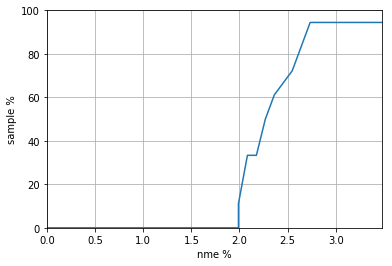

In [26]:
# Test benchmark on minidataset


dataset_dir = '/barn2/yuan/datasets/300W_LP_mini/json'
nmes = run_benchmark(dataset_dir)
os.makedirs('/barn2/yuan/crafting/face_landmark/data',exist_ok=True)
np.save(file='/barn2/yuan/crafting/face_landmark/data/nmes_300W_LP_mini.npy',arr=nmes)
plot_cdf(np.array(nmes), '/barn2/yuan/crafting/face_landmark/data/nmes_300W_LP_mini.png')
#plot_cdf(np.array(nmes_v2))

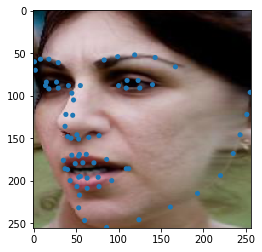

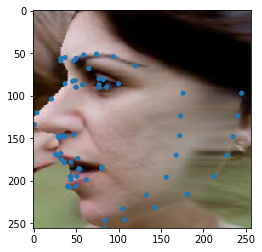

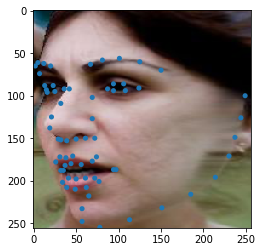

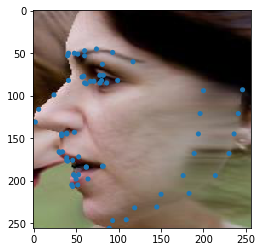

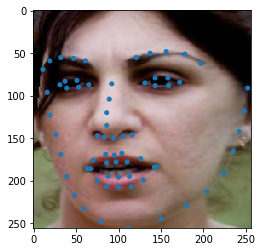

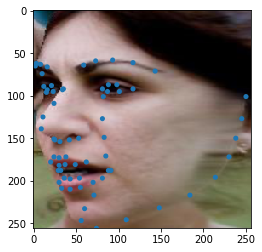

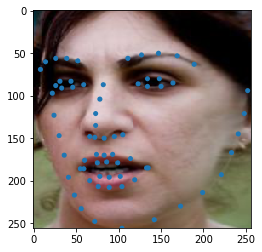

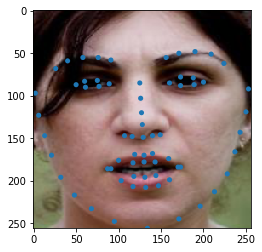

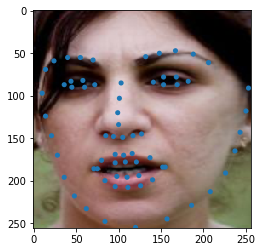

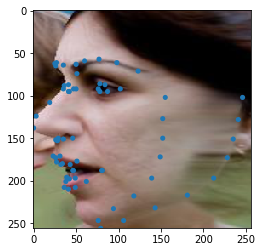

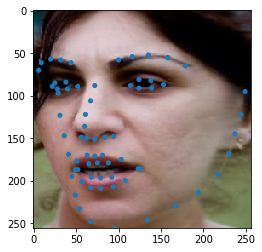

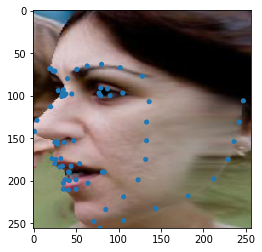

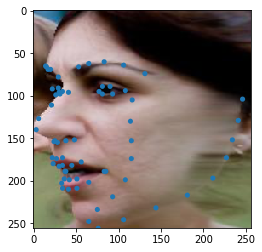

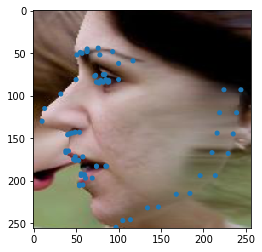

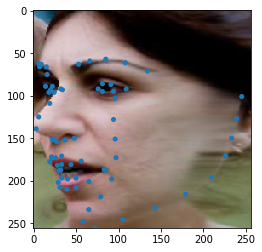

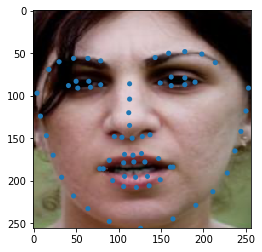

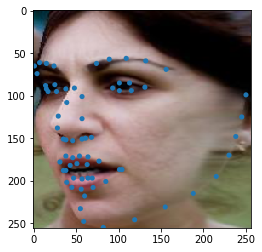

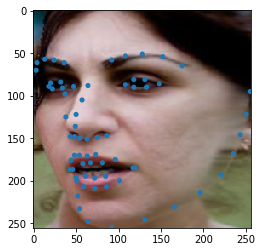

In [78]:
dataset_dir = '/barn2/yuan/datasets/300W_LP_mini/json'
dataset = Dataset()
nmes = run_imagemark(dataset, dataset_dir)

In [79]:
print(np.abs(dataset.landmark_xmax_stat).max())
print(np.abs(dataset.landmark_xmin_stat).max())
print(np.abs(dataset.landmark_ymax_stat).max())
print(dataset.landmark_ymin_stat)
print(np.mean(dataset.aspect_ratio_stat))

0.04529222
0.044707112
0.04845556
[-0.21218736, -0.20472787, -0.22928365, -0.18314877, -0.19821207, -0.23708884, -0.20451978, -0.19752908, -0.1949706, -0.23170595, -0.21226048, -0.2549001, -0.24626863, -0.1774286, -0.23625131, -0.19685765, -0.22718368, -0.20926136]
1.2899084


In [82]:
dataset_dir = '/barn2/yuan/datasets/300W_LP/json'
dataset = Dataset()
nmes = run_imagemark(dataset, dataset_dir, render=False)

In [85]:
print(np.mean(dataset.landmark_xmax_stat).max())
print(np.mean(dataset.landmark_xmin_stat).max())
print(np.mean(dataset.landmark_ymax_stat).max())
print(np.mean(dataset.landmark_ymin_stat))
print(np.mean(dataset.aspect_ratio_stat))

-0.010988843
0.01721394
-0.05291888
-0.2055593
1.2973754


In [88]:
!pip install seaborn

    100% |████████████████████████████████| 215kB 7.0MB/s ta 0:00:01


/home/yuanliu/vroot/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


(-0.3, 0.3)

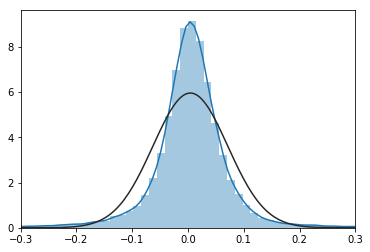

In [106]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from scipy.stats import norm

tmp = np.array(dataset.landmark_xmax_stat)
tmp = tmp[tmp > -0.35]
tmp = tmp[tmp < 0.35]
dist = sns.distplot(tmp, fit=norm, kde=True)

axes = dist.axes
axes.set_xlim(-0.3,0.3)

/home/yuanliu/vroot/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


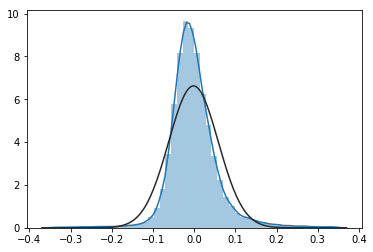

In [107]:
tmp = np.array(dataset.landmark_xmin_stat)
tmp = tmp[tmp > -0.35]
tmp = tmp[tmp < 0.35]
dist = sns.distplot(tmp, fit=norm, kde=True)

axes = dist.axes
#axes.set_xlim(-0.3,0.3)

/home/yuanliu/vroot/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


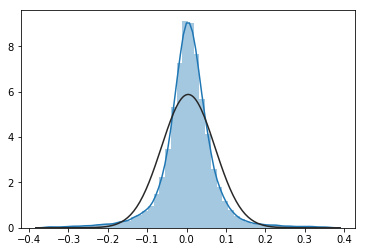

In [111]:
tmp = np.array(dataset.landmark_xmax_stat)
tmp = tmp[tmp > -0.35 + tmp.mean()]
tmp = tmp[tmp < 0.35+ tmp.mean()]
dist = sns.distplot(tmp, fit=norm, kde=True)

axes = dist.axes
#axes.set_xlim(-0.3,0.3)

/home/yuanliu/vroot/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


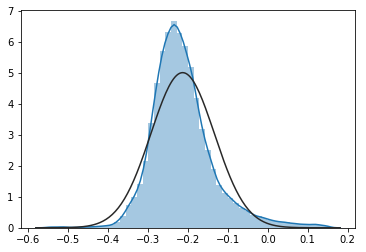

In [109]:
tmp = np.array(dataset.landmark_ymin_stat)
tmp = tmp[tmp > -0.35 + tmp.mean()]
tmp = tmp[tmp < 0.35+ tmp.mean()]
dist = sns.distplot(tmp, fit=norm, kde=True)

axes = dist.axes
#axes.set_xlim(-0.3,0.3)

/home/yuanliu/vroot/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


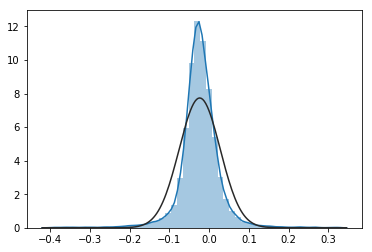

In [110]:
tmp = np.array(dataset.landmark_ymax_stat)
tmp = tmp[tmp > -0.35 + tmp.mean()]
tmp = tmp[tmp < 0.35+ tmp.mean()]
dist = sns.distplot(tmp, fit=norm, kde=True)

axes = dist.axes
#axes.set_xlim(-0.3,0.3)

/home/yuanliu/vroot/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


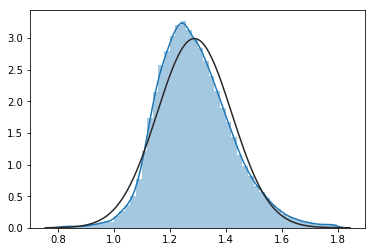

In [113]:
tmp = np.array(dataset.aspect_ratio_stat)
tmp = tmp[tmp > -0.5 + tmp.mean()]
tmp = tmp[tmp < 0.5+ tmp.mean()]
dist = sns.distplot(tmp, fit=norm, kde=True)

axes = dist.axes
#axes.set_xlim(-0.3,0.3)

INFO:tensorflow:Restoring parameters from /barn2/yuan/saved_model/3D-FAN-NHWC-0/variables/variables


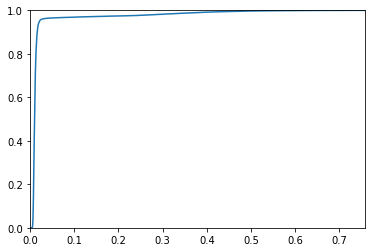

In [109]:
# Test benchmark on full dataset
from face_landmark import load_dataset
from face_landmark.metric import nme
from face_landmark.fan_tf import util_official as uo
import torch

dataset_dir = '/barn2/yuan/datasets/300W_LP/json'
nmes = run_benchmark(dataset_dir)
os.makedirs('/barn2/yuan/crafting/face_landmark/data',exist_ok=True)
np.save(file='/barn2/yuan/crafting/face_landmark/data/nmes_300W_LP_corrected.npy',arr=nmes)
plot_cdf(np.array(nmes), '/barn2/yuan/crafting/face_landmark/data/nmes_300W_LP_corrected.png')


(61225,)


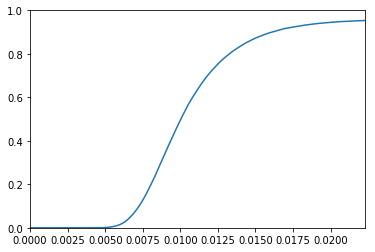

In [142]:
nmes_ = np.load('/barn2/yuan/crafting/face_landmark/data/nmes_300W_LP_corrected.npy')
print(nmes_.shape)
plot_cdf(np.array(nmes_), '/barn2/yuan/crafting/face_landmark/data/nmes_300W_LP_corrected_2.png')

In [72]:
np.linalg.norm(n1)

5.0

In [73]:
np.linalg.norm(n1, axis=0)

array([0., 5.])

In [74]:
np.linalg.norm(n1, axis=1)

array([3., 4.])

In [102]:
from face_landmark import metric

In [103]:
metric.nme_v2

<function face_landmark.metric.nme_v2(x:numpy.ndarray, y:numpy.ndarray, d)>

In [7]:
import re
from utils import pipeline
from torch.utils.serialization import load_lua
#from scipy.ndimage import imread  # deprecated
from PIL import Image
def replace_ext(source_filename, source_ext='.jpg', dest_ext='.npy'):
    pattern = re.compile('([ \\S]+)'+source_ext)
    match = pattern.fullmatch(source_filename)
    if match is None:
        return None
    for matched_str in match.groups():
        return matched_str + dest_ext

class DatasetIterator_AFLW2000(object):
    def __init__(self, dump_dir):
        image_filenames = pipeline.search_files(dir=dump_dir, pattern=r'([ \S]+).jpg')
        anno_filenames = [replace_ext(image_filename) for image_filename in image_filenames]
        self.anno_filenames = anno_filenames
        self.image_filenames = image_filenames
        self.cnt = 0
        return

    def __iter__(self):
        self.cnt = 0
        return self

    def __next__(self):
        if self.cnt >= len(self.anno_filenames):
            raise StopIteration
        else:
            anno_path = self.anno_filenames[self.cnt]
            img_path = self.image_filenames[self.cnt]
            anno_3d = np.load(anno_path)[:,:2]
            img = np.array(Image.open(fp=img_path))
            #img = imread(img_path, flatten=False, mode='RGB')
            self.cnt += 1
            return (None, anno_3d), img

    def __len__(self):
        return len(self.anno_filenames)
    
class DatasetIterator_AFLW2000_Re(object):
    def __init__(self, dump_dir, offset=False):
        image_filenames = pipeline.search_files(dir=dump_dir, pattern=r'([ \S]+).jpg')
        anno_filenames = [replace_ext(image_filename, dest_ext='.t7') for image_filename in image_filenames]
        self.anno_filenames = anno_filenames
        self.image_filenames = image_filenames
        self.cnt = 0
        self.offset = offset
        return

    def __iter__(self):
        self.cnt = 0
        return self

    def __next__(self):
        if self.cnt >= len(self.anno_filenames):
            raise StopIteration
        else:
            anno_path = self.anno_filenames[self.cnt]
            img_path = self.image_filenames[self.cnt]
            anno_3d = load_lua(anno_path).numpy().astype(np.float32)
            if self.offset:
                anno_3d = anno_3d - 1
            #img = imread(img_path, flatten=False, mode='RGB')
            img = np.array(Image.open(fp=img_path))
            self.cnt += 1
            return (None, anno_3d), img

    def __len__(self):
        return len(self.anno_filenames)

In [171]:
# load AFLW
aflw_dir = '/barn2/yuan/AFLW2000-3D'
aflw_iterator = DatasetIterator_AFLW2000(aflw_dir)
print(len(aflw_iterator))

1994


INFO:tensorflow:Restoring parameters from /barn2/yuan/saved_model/3D-FAN-NHWC-0/variables/variables


/home/yuanliu/vroot/lib/python3.6/site-packages/ipykernel_launcher.py:32: DeprecationWarning: `imread` is deprecated!
`imread` is deprecated in SciPy 1.0.0.
Use ``matplotlib.pyplot.imread`` instead.


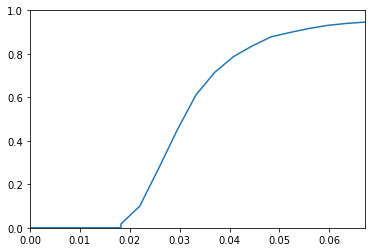

In [172]:
nmes = run_benchmark(iterator=aflw_iterator)
plot_cdf(np.array(nmes))

In [183]:
from PIL import Image
path = '/barn2/yuan/AFLW2000-3D-Reannotated/image01649.t7'
imp = '/barn2/yuan/AFLW2000-3D-Reannotated/image01649.jpg'
dddd = load_lua(path).numpy()
im = Image.open(imp)
imnp = np.array(im)
print(im.mode, im.size, imnp.shape)
print(dddd.shape)
print(dddd.dtype)

RGB (450, 450) (450, 450, 3)
(68, 2)
float64


1998
INFO:tensorflow:Restoring parameters from /barn2/yuan/saved_model/3D-FAN-NHWC-0/variables/variables


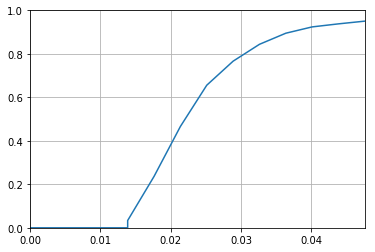

In [8]:
aflw_dir_re = '/barn2/yuan/AFLW2000-3D-Reannotated'
aflw_re_iterator = DatasetIterator_AFLW2000_Re(aflw_dir_re)
print(len(aflw_re_iterator))
nmes = run_benchmark(iterator=aflw_re_iterator)


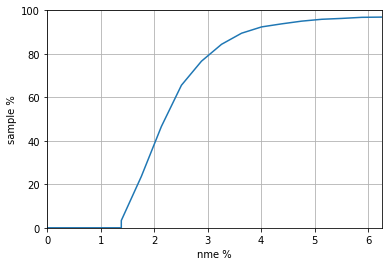

In [17]:
plot_cdf(np.array(nmes))

1998
INFO:tensorflow:Restoring parameters from /barn2/yuan/saved_model/3D-FAN-NHWC-0/variables/variables


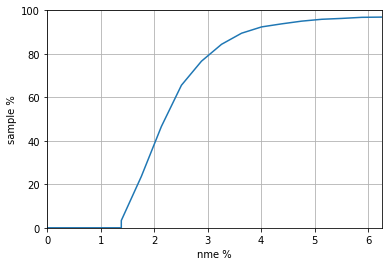

In [27]:
aflw_dir_re = '/barn2/yuan/AFLW2000-3D-Reannotated'
aflw_re_iterator = DatasetIterator_AFLW2000_Re(aflw_dir_re, offset=False)
print(len(aflw_re_iterator))
nmes = run_benchmark(iterator=aflw_re_iterator)
plot_cdf(np.array(nmes))